9장. 고급 분류 기법: 커널 기법과 SVM
====




        (주)디티웨어 대표이사 김덕태

              2015. 7. 3.

- download data and code examples in book
  - https://github.com/cataska/programming-collective-intelligence-code/tree/master/chapter9


# 목차
- 중매 데이터 세트
- 데이터를 다루는 어려움
- 기본 선형 분류
- 분류 데이터의 특성
- 데이터 축적 조정
- 커널 기법 이해
- 지지벡터머신
- LIBSVM 사용
- 페이스북 매칭
- 함께 풀어보기


# 중매 데이터 세트

## 수집 정보
- 나이
- 흡연 여부
- 자녀 희망
- 관심 목록
- 거주지

## 데이터 파일

In [1]:
%cd ..
%ls

/Volumes/C/tnb/ai/Programming Collective Intelligence
20150410-intro.md
Programming Collective Intelligence.pdf
Programming Collective Intelligence.xml
Programming Collective Intelligence.xml~
book-git/
ch02-making-recommendations.xml
ch04-검색과 랭킹.pdf
ch05-최적화.pdf
ch09-고급분류기법-커널 기법과 SVM/
ch1-introduction.xml
study-git/


In [ ]:
%%script c:\git\bin\git clone https://github.com/cataska/programming-collective-intelligence-code book-git

In [2]:
%cd book-git/chapter9
%ls

/Volumes/C/tnb/ai/Programming Collective Intelligence/book-git/chapter9
advancedclassify.py   facebook.py           matchmaker.csv        svmutil.py
advancedclassify.pyc  libsvm-3.20/          svm.py                svmutil.pyc
agesonly.csv          libsvm-git/           svm.pyc               test.model


### matchmaker.csv
- 각 가로줄: 남자와 여자에 대한 정보
- 마지막 세로줄: 0 or 1. 좋은 중매감인지 여부

In [3]:
%less matchmaker.csv

### agesonly.csv
- 나이에만 기반한 중매 정보

In [47]:
%less agesonly.csv

### Example code - advancedclassify.py

In [4]:
# %load advancedclassify.py
class matchrow:
  def __init__(self,row,allnum=False):
    if allnum:
      self.data=[float(row[i]) for i in range(len(row)-1)]
    else:
      self.data=row[0:len(row)-1]
    self.match=int(row[len(row)-1])

def loadmatch(f,allnum=False):
  rows=[]
  for line in file(f):
    rows.append(matchrow(line.split(','),allnum))
  return rows
 
from pylab import *
def plotagematches(rows):
  xdm,ydm=[r.data[0] for r in rows if r.match==1],\
          [r.data[1] for r in rows if r.match==1]
  xdn,ydn=[r.data[0] for r in rows if r.match==0],\
          [r.data[1] for r in rows if r.match==0] 
  
  plot(xdm,ydm,'bo')
  plot(xdn,ydn,'b+')
  
  show()

def lineartrain(rows):
  averages={}
  counts={}
  
  for row in rows:
    # Get the class of this point
    cl=row.match
    
    averages.setdefault(cl,[0.0]*(len(row.data)))
    counts.setdefault(cl,0)
    
    # Add this point to the averages
    for i in range(len(row.data)):
      averages[cl][i]+=float(row.data[i])
      
    # Keep track of how many points in each class
    counts[cl]+=1
    
  # Divide sums by counts to get the averages
  for cl,avg in averages.items():
    for i in range(len(avg)):
      avg[i]/=counts[cl]
  
  return averages

def dotproduct(v1,v2):
  return sum([v1[i]*v2[i] for i in range(len(v1))])

def veclength(v):
  return sum([p**2 for p in v])

def dpclassify(point,avgs):
  b=(dotproduct(avgs[1],avgs[1])-dotproduct(avgs[0],avgs[0]))/2
  y=dotproduct(point,avgs[0])-dotproduct(point,avgs[1])+b
  if y>0: return 0
  else: return 1

def yesno(v):
  if v=='yes': return 1
  elif v=='no': return -1
  else: return 0
  
def matchcount(interest1,interest2):
  l1=interest1.split(':')
  l2=interest2.split(':')
  x=0
  for v in l1:
    if v in l2: x+=1
  return x

yahookey="YOUR API KEY"
from xml.dom.minidom import parseString
from urllib import urlopen,quote_plus

loc_cache={}
def getlocation(address):
  if address in loc_cache: return loc_cache[address]
  data=urlopen('http://api.local.yahoo.com/MapsService/V1/'+\
               'geocode?appid=%s&location=%s' %
               (yahookey,quote_plus(address))).read()
  doc=parseString(data)
  lat=doc.getElementsByTagName('Latitude')[0].firstChild.nodeValue
  long=doc.getElementsByTagName('Longitude')[0].firstChild.nodeValue  
  loc_cache[address]=(float(lat),float(long))
  return loc_cache[address]

def milesdistance(a1,a2):
  lat1,long1=getlocation(a1)
  lat2,long2=getlocation(a2)
  latdif=69.1*(lat2-lat1)
  longdif=53.0*(long2-long1)
  return (latdif**2+longdif**2)**.5

def loadnumerical():
  oldrows=loadmatch('matchmaker.csv')
  newrows=[]
  for row in oldrows:
    d=row.data
    data=[float(d[0]),yesno(d[1]),yesno(d[2]),
          float(d[5]),yesno(d[6]),yesno(d[7]),
          matchcount(d[3],d[8]),
          milesdistance(d[4],d[9]),
          row.match]
    newrows.append(matchrow(data))
  return newrows

def scaledata(rows):
  low=[999999999.0]*len(rows[0].data)
  high=[-999999999.0]*len(rows[0].data)
  # Find the lowest and highest values
  for row in rows:
    d=row.data
    for i in range(len(d)):
      if d[i]<low[i]: low[i]=d[i]
      if d[i]>high[i]: high[i]=d[i]
  
  # Create a function that scales data
  def scaleinput(d):
     return [(d[i]-low[i])/(high[i]-low[i])
            for i in range(len(low))]
  
  # Scale all the data
  newrows=[matchrow(scaleinput(row.data)+[row.match])
           for row in rows]
  
  # Return the new data and the function
  return newrows,scaleinput


def rbf(v1,v2,gamma=10):
  dv=[v1[i]-v2[i] for i in range(len(v1))]
  l=veclength(dv)
  return math.e**(-gamma*l)

def nlclassify(point,rows,offset,gamma=10):
  sum0=0.0
  sum1=0.0
  count0=0
  count1=0
  
  for row in rows:
    if row.match==0:
      sum0+=rbf(point,row.data,gamma)
      count0+=1
    else:
      sum1+=rbf(point,row.data,gamma)
      count1+=1
  y=(1.0/count0)*sum0-(1.0/count1)*sum1+offset

  if y>0: return 0
  else: return 1

def getoffset(rows,gamma=10):
  l0=[]
  l1=[]
  for row in rows:
    if row.match==0: l0.append(row.data)
    else: l1.append(row.data)
  sum0=sum(sum([rbf(v1,v2,gamma) for v1 in l0]) for v2 in l0)
  sum1=sum(sum([rbf(v1,v2,gamma) for v1 in l1]) for v2 in l1)
  
  return (1.0/(len(l1)**2))*sum1-(1.0/(len(l0)**2))*sum0


### loadmatch 함수
- mathrow class instance들의 리스트를 만든다.

## 데이터 세트 (agesonly.csv, matchmaker.csv 파일) 로드

In [5]:
import advancedclassify
agesonly=advancedclassify.loadmatch('agesonly.csv', allnum=True)
matchmaker=advancedclassify.loadmatch('matchmaker.csv')

In [6]:
matchmaker

[<advancedclassify.matchrow instance at 0x1059763b0>,
 <advancedclassify.matchrow instance at 0x1085c4200>,
 <advancedclassify.matchrow instance at 0x1085c4d40>,
 <advancedclassify.matchrow instance at 0x1085c4638>,
 <advancedclassify.matchrow instance at 0x1085c43f8>,
 <advancedclassify.matchrow instance at 0x1085c4c20>,
 <advancedclassify.matchrow instance at 0x1085c4c68>,
 <advancedclassify.matchrow instance at 0x1085c47e8>,
 <advancedclassify.matchrow instance at 0x1085c4fc8>,
 <advancedclassify.matchrow instance at 0x1085c4248>,
 <advancedclassify.matchrow instance at 0x1085c4f80>,
 <advancedclassify.matchrow instance at 0x1085c46c8>,
 <advancedclassify.matchrow instance at 0x1085c4dd0>,
 <advancedclassify.matchrow instance at 0x1085c4998>,
 <advancedclassify.matchrow instance at 0x1083b5d40>,
 <advancedclassify.matchrow instance at 0x1083b53b0>,
 <advancedclassify.matchrow instance at 0x1083b5830>,
 <advancedclassify.matchrow instance at 0x1083b5290>,
 <advancedclassify.matchrow 

#2. 데이터를 다루는 어려움

## 중매 데이터의 특성
- 비선형(nonlinearity)
- 변수 간 상호작용 (interplay)

## 시각화
- 남성 나이 대 여성 나이 산포도(scatter plot)
- O: 베필임
- +: 베필 아님
- 결론
  - 사람들은 각자의 나이 범위 내에서만 만남. 그러나, 이 경계는 나이가 들어감에 따라 불명확해짐
  - x: 남자로 추정, y: 여자로 추정
  - 남자 나이 25살까지 자기보다 나이어리거나 약간 많은 여자와 배필이 된다.
  - 남자 나이 30살 이상이면, 17 ~ 50세의 여자와 배필이 된다.
  - 여자 나이 30살이면, 25 ~ 50세의 남자와 배필이 된다.

In [7]:
%matplotlib inline

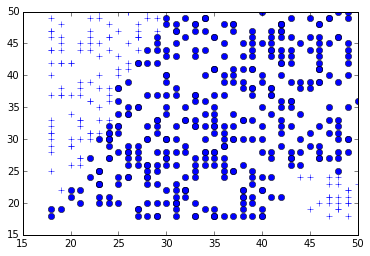

In [8]:
advancedclassify.plotagematches(agesonly)

## 의사결정트리 분류기
### Boundary creaed by a dicision tree

![](Boundary created by a dicision tree.png)

### Decision tree for curved boundary

![](Decision tree for curved boundary.png)


- 다중 숫자 입력들을 가진 문제에서 분류 결정이 종종 잘 동작하지 않음
"

### 단점
- 의사 결정 트리가 혼란스럽고 경직되어 있음
- 다중 숫자 입력들을 가진 문제에서 분류 결정이 종종 잘 동작하지 않음


#3. 기본 선형 분류

## 방법
- 각 범주(class) 내 모든 데이터들의 평균점(average point) 계산
- 범주의 중앙을 나타내는 점을 생성

## 실행 결과

- X 점: 각각의 평균점을 의미
- 분류 기준: 주어진 점이 어느 중앙점(ceter point, 여기서는 평균점을 사용함)이 가장 근접한지 판단
- 분류선: 중앙점으로부터 분류선이 유도됨


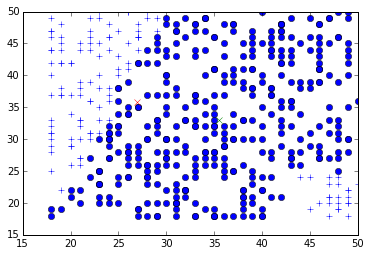

In [9]:
xdm,ydm=[r.data[0] for r in agesonly if r.match==1],\
        [r.data[1] for r in agesonly if r.match==1]
xdn,ydn=[r.data[0] for r in agesonly if r.match==0],\
        [r.data[1] for r in agesonly if r.match==0] 
  
plot(xdm,ydm,'bo')
plot(xdn,ydn,'b+')

avgs=advancedclassify.lineartrain(agesonly)

plot(avgs[1][0],avgs[1][1],'gx')
plot(avgs[0][0],avgs[0][1],'rx')
  
show()

![](Linear classifier using aerages.png)

In [10]:
advancedclassify.dpclassify([30, 30], avgs)

1

In [11]:
advancedclassify.dpclassify([30, 25], avgs)

1

In [12]:
advancedclassify.dpclassify([25, 40], avgs)

0

In [13]:
advancedclassify.dpclassify([48, 20], avgs)

1

## 단점
- 데이터를 직선으로 나눌 수 없는 경우나 다중 영역을 가진 경우 (본 예제처럼)에는 부정확하다
  - 예) 남자 48세와 여자 20세가 배필인 것으로 오분류함
- 커널 기법을 사용하면 선형 분류기를 개선해서 비선형 분류를 할 수 있다.


#7. 지지벡터머신(SVM)

## Linear average classifier misclassifies points

![](Linear average classifier misclassifies points.png)

## Finding the best dividing line

![](Finding the best dividing line.png)

## 방법
- 지지 벡터 머신은 각 범주에서 가장 멀리 떨어진 선을 찾는다. 이 선을 최대허용 초평면(maximum-margin hyperplane)이라고 한다.
- 구분선 근처의 점들을 지지 벡터(support vector)라고 부른다.
- SVM은 지지 벡터를 찾고 이를 이용한 구분선을 찾는 알고리듬이다.

## 장점
- 고차원 데이터 세트에 잘 동작한다.


#8. LIBSVM 사용

- SVM 오픈 소스 라이브러리
- C++ 버전, 자바 버전, svm.py(파이썬 래퍼)

## 설치 방법
- 다운로드: <http://www.csie.ntu.edu.tw/~cjlin/libsvm>
- 책의 설치 방법은 책 github에 포함된 svm.py는 libsvm 최신 버전에 맞게 동작하지 않으므로 다음과 같이 한ㅇ다.


In [14]:
!c:\git\bin\git clone https://github.com/cjlin1/libsvm libsvm-git


/bin/sh: c:gitbingit: command not found


- for 32 bit windows

In [10]:
#copy libsvm-git/windows/libsvm.dll c:/windows/system32

- overwrite svm.py in book github with svm.py in libsvm github

In [11]:
#copy libsvm-git\python\svm.py .

## 간단한 libsvm 테스트

In [15]:
from svm import *
from svmutil import *

# 첫번째 리스트: 범주
# 두번째 리스트: 입력 데이터
prob = svm_problem([1,-1], [[1,0,1], [-1,0,1]])

# svm_parameter 만들어 사용할 커널 기법을 명시
#param = svm_parameter(kernel_type = LINEAR, C = 10)
param = svm_parameter()
param.kernel_type = LINEAR
param.C = 10

# 이 모델로 학습
m = svm_train(prob, param)

# 새로운 데이터로 예측
svm_predict([0], [[1, 1, 1]], m)

Exception: LIBSVM library not found.

In [56]:
## 모델을 저장하고 로드
svm_save_model('test.model', m)
m = svm_load_model('test.model')

## 중매 데이터 세트에 SVM 적용하기


In [18]:
answers,inputs = [r.match for r in agesonly], [r.data for r in agesonly]
param = svm_parameter()
param.kernel_type = RBF
prob = svm_problem(answers,inputs)
m = svm_train(prob, param)

In [19]:
# 남자는 자녀를 원하지 않고, 여자는 자녀를 원하는 경우
newrow=[28.0,-1,-1,26.0,-1,1,2,0.8]
svm_predict([0], [newrow], m)

Accuracy = 0% (0/1) (classification)


([1.0], (0.0, 1.0, nan), [[0.5069428452968884]])

In [14]:
# 둘 다 자녀를 원하는 경우
newrow=[28.0,-1,-1,26.0,-1,1,2,0.8]
svm_predict([0], [newrow], m)

Accuracy = 0% (0/1) (classification)


([1.0], (0.0, 1.0, nan), [[0.5069428452968884]])

### 모델에 대한 교차 검증
- 데이터 세트를 다음과 같이 자동 구분
  - 학습 세트: 모델 구축에 사용
  - 검증 세트로 자동 구분: 예측이 얼마나 잘되었는지 확인
- cross_validation(prob, param, n) function in svm.py
  - 데이터 세트를 n 부분 세트로 분리한 후, 각 부분 세트를 검사 세트로 사용하고 나머지 부분세트를가지고 모델을 학습


In [21]:
guesses = svm_cross_validation(prob, param, 4)
guesses
sum([abs(answers[i]-guesses[i]) for i in range(len(guesses))])

NameError: name 'svm_cross_validation' is not defined

In [25]:
param = svm_parameter()
param.cross_validation = True
param.nr_fold = 4
svm_train(prob, param)
guesses
# sum([abs(answers[i]-guesses[i]) for i in range(len(guesses))])

Cross Validation Accuracy = 95.6%


95.0

In [24]:
guesses

95.0